Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        26
           1       0.68      0.72      0.70        18
           2       0.60      0.67      0.63        18
           3       0.39      0.50      0.44        18

    accuracy                           0.62        80
   macro avg       0.64      0.63      0.63        80
weighted avg       0.67      0.62      0.64        80



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 562ms/step - accuracy: 0.3156 - loss: 4.0881 - val_accuracy: 0.2625 - val_loss: 1.3737
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.6480 - loss: 1.1275 - val_accuracy: 0.1625 - val_loss: 1.8095
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.7660 - loss: 0.7405 - val_accuracy: 0.2125 - val_loss: 3.2439
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - accuracy: 0.8317 - loss: 0.4075 - val_accuracy: 0.2250 - val_loss: 4.5160
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - accuracy: 0.9106 - loss: 0.2963 - val_accuracy: 0.2125 - val_loss: 5.1432
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.9664 - loss: 0.1536 - val_accuracy: 0.2250 - val_loss: 6.0110
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.27      0.89      0.42        18
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


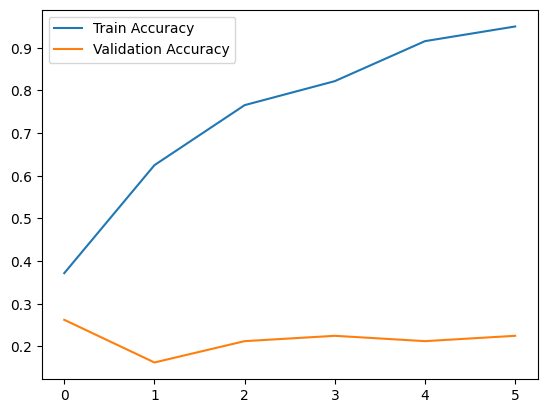

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Set paths
data_path = "/content/drive/MyDrive/Machine Learning Lab/Lab_Project/Machine_leaning/Dataset"  # Update this with your dataset path
categories = os.listdir(data_path)

# Parameters
img_size = 64  # Resize images to 64x64

# Load and preprocess data
def load_data():
    X, y = [], []
    failed_images = 0
    for label, category in enumerate(categories):
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                failed_images += 1
    if failed_images > 0:
      print(f"Total {failed_images} failed to load.")
    return np.array(X), np.array(y)

X, y = load_data()

# Scale pixel values
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, img_size * img_size * 3)).reshape(-1, img_size, img_size, 3)
y = to_categorical(y, num_classes=len(categories))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Conventional Approach (Feature Extraction + Random Forest)
def extract_features(images):
    features = []
    for img in images:
        # Convert the image to uint8 format
        img_uint8 = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
        hog = cv2.HOGDescriptor((img_size, img_size), (8, 8), (2, 2), (2, 2), 9)
        h = hog.compute(gray)
        features.append(h.flatten())
    return np.array(features)

X_train_feat = extract_features(X_train)
X_test_feat = extract_features(X_test)

# Hyperparameter tuning for Random Forest
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier()
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=3, random_state=42)
random_search.fit(X_train_feat, y_train.argmax(axis=1))
rf_model = random_search.best_estimator_

rf_preds = rf_model.predict(X_test_feat)
print("Random Forest Classification Report:")
print(classification_report(y_test.argmax(axis=1), rf_preds))

# CNN Approach
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = cnn_model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate CNN Model
cnn_preds = cnn_model.predict(X_test).argmax(axis=1)
print("CNN Classification Report:")
print(classification_report(y_test.argmax(axis=1), cnn_preds))

# Plot CNN Training History
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()